In [1]:
import pandas as pd


from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
#importing tensorflow
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random as rn
import datetime

In [2]:
data=pd.read_csv(r"C:\Users\91996\Desktop\ML\plant_pathology\train.csv")

In [3]:
data['image']=r"C://Users//91996//Desktop//ML//plant_pathology//train_images//"+data['image'].astype('str')

In [4]:
data.head()

,image,labels
0,C://Users//91996//Desktop//ML//plant_pathology...,healthy
1,C://Users//91996//Desktop//ML//plant_pathology...,scab frog_eye_leaf_spot complex
2,C://Users//91996//Desktop//ML//plant_pathology...,scab
3,C://Users//91996//Desktop//ML//plant_pathology...,scab
4,C://Users//91996//Desktop//ML//plant_pathology...,complex


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['image'],data['labels'], test_size=0.33, random_state=42)

In [6]:
print(X_train.size,y_train.size)
print(X_test.size,y_test.size)

12483 12483
6149 6149


In [7]:
print(y_train.head())

10168    frog_eye_leaf_spot
3804                   scab
15624    frog_eye_leaf_spot
8892                complex
17388               healthy
Name: labels, dtype: object


In [8]:
image = pd.DataFrame({'image' : X_train})
labels = pd.DataFrame({'labels': y_train})
dtrain = image.join(labels)

In [9]:
image = pd.DataFrame({'image' : X_test})
labels = pd.DataFrame({'labels': y_test})
dtest = image.join(labels)

In [10]:
print(dtrain.shape)
print(dtest.shape)

(12483, 2)
(6149, 2)


In [11]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        fill_mode= 'nearest',
        horizontal_flip=True,
        vertical_flip=True,
        height_shift_range=2,
        validation_split = 0.2)
generator_train = train_datagen.flow_from_dataframe(dtrain,  x_col='image', y_col="labels", class_mode="categorical",validate_filenames = False ,subet='training',target_size=(256,256), batch_size=8)


test_datagen= ImageDataGenerator(rescale=1./255)

generator_test=test_datagen.flow_from_dataframe(dtest,  x_col='image', y_col="labels", class_mode="categorical",validate_filenames = False ,subet='training',target_size=(256,256), batch_size=8)

Found 12483 non-validated image filenames belonging to 12 classes.
Found 6149 non-validated image filenames belonging to 12 classes.


In [12]:
Xception_last = tf.keras.applications.Xception(weights='imagenet',include_top=False,input_shape=(256,256,3))
for layer in Xception_last.layers:
    layer.trainable = True
Xception_last.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

model_tweaking_last_layers = tf.keras.models.Sequential([
    Xception_last,
    Conv2D(64,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu',data_format='channels_last',kernel_initializer=tf.keras.initializers.he_normal(seed=0)),
    Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='valid',activation='relu',data_format='channels_last',kernel_initializer=tf.keras.initializers.he_normal(seed=0)),
    Flatten(data_format='channels_last',name='Flatten'),
    Dense(units=12,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal)
])

model_tweaking_last_layers.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          3276864   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                12300     
Total params: 24,154,804
Trainable params: 24,100,276
Non-trainable params: 54,528
_________________________________________________________________


In [34]:
from sklearn.metrics import f1_score
def f1(y_true,y_pred):
    return f1_score(y_true,y_pred,average="micro")

def micro_f1(y_true,y_pred):
    y_pred=tf.math.argmax(y_pred,axis=1)
    y_true=tf.math.argmax(y_true,axis=1)
    return tf.py_function(f1,(y_true,y_pred),tf.double)

In [35]:

model_tweaking_last_layers.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.01),loss='categorical_crossentropy',metrics=[micro_f1])


In [36]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.001)

checkpoint = ModelCheckpoint(r'C:\Users\91996\Desktop\ML\plant_pathology\tweaking_last_layers_xception.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
callbacks = [reduce_lr]

In [37]:
history_tweaking_xception=model_tweaking_last_layers.fit(generator_train,validation_data=generator_test,steps_per_epoch=100,validation_steps=150,epochs=20,verbose=1,callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 395s 4s/step - loss: 1.4691 - micro_f1: 0.5038 - val_loss: 1.3607 - val_micro_f1: 0.5483
Epoch 2/20
100/100 [==============================] - 391s 4s/step - loss: 1.0643 - micro_f1: 0.6525 - val_loss: 0.9476 - val_micro_f1: 0.7158
Epoch 3/20
100/100 [==============================] - 421s 4s/step - loss: 1.0354 - micro_f1: 0.6787 - val_loss: 0.9735 - val_micro_f1: 0.6700
Epoch 4/20
100/100 [==============================] - 634s 6s/step - loss: 0.9555 - micro_f1: 0.7163 - val_loss: 1.0063 - val_micro_f1: 0.7042
Epoch 5/20
100/100 [==============================] - 368s 4s/step - loss: 0.9319 - micro_f1: 0.7212 - val_loss: 0.7834 - val_micro_f1: 0.7533
Epoch 6/20
100/100 [==============================] - 322s 3s/step - loss: 0.9019 - micro_f1: 0.6925 - val_loss: 0.7473 - val_micro_f1: 0.7750
Epoch 7/20
100/100 [==============================] - 333s 3s/step - loss: 0.7308 - micro_f1: 0.7688 - val_loss: 0.7097 - val_micro_f1: 0.7842

In [120]:
image = tf.keras.preprocessing.image.load_img(r'C:\Users\91996\Desktop\ML\plant_pathology\test_images\85f8cb619c66b863.jpg', color_mode='rgb',target_size=(256, 256))

In [121]:
from tensorflow.keras.preprocessing.image import img_to_array

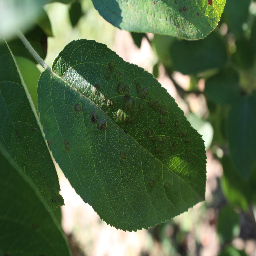

In [122]:
display(image)

In [123]:
x = tf.keras.preprocessing.image.img_to_array(image)
print(x.shape)
image = np.expand_dims(x,axis=0)
print(image.shape)

(256, 256, 3)
(1, 256, 256, 3)


In [118]:
pi=tf.keras.applications.xception.preprocess_input
x=pi(x)

In [125]:
features=model_tweaking_last_layers.predict(image)